In [75]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from random import randint
import sklearn.metrics as skm
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import imputation
from sklearn.impute import SimpleImputer

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
def replace_rare_entries(df, columns, threshold_frac):
    tot_instances = df.shape[0]
    threshold = tot_instances * threshold_frac
    df = df.apply(lambda x: x.mask(x.map(x.value_counts()) < threshold, 'RARE') if x.name in columns else x)
    return df
    

In [4]:
categorical = [
    'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Dest', 'DepTimeBlk', 'DayOfYear', 
    'weather_label', 'PlaneModel'
]

In [5]:
continuous = [
    'DistanceGroup', 'Distance', 'ArrDelay0', 'DepDelay1', 'ArrDelay1', 'DepDelay2', 'ArrDelay2',
    'DepDelay3', 'IncomingAirTime', 'IncomingDistance', 'IncomingDistanceGroup', 'ArrTimeBlkLoad',
    'ArrDailyLoad', 'DepTimeBlkLoad', 'DepDailyLoad', 'TotalTimeBlkLoad', 'TotalDailyLoad', 
    'precipitation_intensity', 'precipitation_probability', 'visibility', 'cloud_cover',
    'humidity', 'wind_bearing', 'wind_speed', 'uv_index', 'temperature', 'moon_phase',
    'SeatsNum'
]

In [28]:
binary = ['NATIONAL_HOLIDAY', 'CHRISTIAN']

In [29]:
targets = ['DepDelay', 'DepDel15']

In [30]:
cols_to_rmv = ['Year', 'Unnamed: 0', 'ArrDelay0', 'DepDelay1']

In [50]:
categor_keep_all = ['DepTimeBlk', 'DayOfYear', 'weather_label']

In [51]:
# source_path = '/home/dbeiski/Project/data/lga_dep_yearly_enhanced/'
# file_name_list = sorted(os.listdir(source_path))
# columns = categorical + continuous + binary + targets
# df = pd.read_csv(source_path + file_name_list[0], usecols=columns)
# for file_name in file_name_list[1: ]:
#     df_new = pd.read_csv(source_path + file_name, usecols=columns)
#     df = pd.concat([df, df_new])
# df.to_csv('/home/dbeiski/Project/data/all_data_final.csv')

In [52]:
df = pd.read_csv('/home/dbeiski/Project/data/all_data_final.csv')

In [53]:
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,Reporting_Airline,Dest,DepDelay,DepDel15,DepTimeBlk,Distance,DistanceGroup,DayOfYear,ArrDelay0,DepDelay1,ArrDelay1,DepDelay2,ArrDelay2,DepDelay3,IncomingAirTime,IncomingDistance,IncomingDistanceGroup,ArrTimeBlkLoad,ArrDailyLoad,DepTimeBlkLoad,DepDailyLoad,TotalTimeBlkLoad,TotalDailyLoad,weather_label,precipitation_intensity,precipitation_probability,visibility,cloud_cover,humidity,wind_bearing,wind_speed,uv_index,temperature,moon_phase,NATIONAL_HOLIDAY,CHRISTIAN,SeatsNum,PlaneModel
0,0,2014,6,1,7,EV,IAD,-7.0,0.0,1000-1059,229.0,1,06-01,-28.0,-10.0,-3.0,-2.0,73.0,80.0,42.0,229.0,1.0,22.0,294.0,20.0,287.0,42.0,581.0,WeatherLabel.Cloudy,0.0,0.0,16.089,1.0,0.82,148.0,2.11,0.0,20.27,0.13,0.0,1.0,55.0,CL-600-2B19
1,1,2014,6,1,7,UA,IAH,-9.0,0.0,1000-1059,1416.0,6,06-01,-17.0,-5.0,-11.0,0.0,-8.0,2.0,196.0,1620.0,7.0,22.0,294.0,20.0,287.0,42.0,581.0,WeatherLabel.Cloudy,0.0,0.0,16.089,1.0,0.82,148.0,2.11,0.0,20.27,0.13,0.0,1.0,149.0,737-824
2,2,2014,6,1,7,UA,ORD,-6.0,0.0,1000-1059,733.0,3,06-01,-11.0,-1.0,-17.0,-2.0,-31.0,-3.0,189.0,1416.0,6.0,22.0,294.0,20.0,287.0,42.0,581.0,WeatherLabel.Cloudy,0.0,0.0,16.089,1.0,0.82,148.0,2.11,0.0,20.27,0.13,0.0,1.0,200.0,A320-232
3,3,2014,6,1,7,DL,ATL,-3.0,0.0,1000-1059,762.0,4,06-01,-22.0,-4.0,-8.0,-3.0,32.0,32.0,104.0,762.0,4.0,22.0,294.0,20.0,287.0,42.0,581.0,WeatherLabel.Cloudy,0.0,0.0,16.089,1.0,0.82,148.0,2.11,0.0,20.27,0.13,0.0,1.0,142.0,MD-88
4,4,2014,6,1,7,MQ,STL,-7.0,0.0,1000-1059,888.0,4,06-01,15.0,-6.0,-17.0,-3.0,2.0,-7.0,123.0,888.0,4.0,22.0,294.0,20.0,287.0,42.0,581.0,WeatherLabel.Cloudy,0.0,0.0,16.089,1.0,0.82,148.0,2.11,0.0,20.27,0.13,0.0,1.0,NaN,NaN


In [54]:
data = df.drop(columns=(cols_to_rmv + targets), axis=1)
data = replace_rare_entries(data, [col for col in categorical if col not in ['DepTimeBlk', 'DayOfYear', 'weather_label']], 0.005)
data = pd.get_dummies(data, columns=categorical)
label = df['DepDel15']

In [55]:
data = data[~label.isna()]
label = label[~label.isna()]

In [57]:
print('Rows: {}\nFeatures: {}\nLabel-1 Fraction: {}'
      .format(data.shape[0], data.shape[1], label.sum() / label.shape[0]))

Rows: 580685
Features: 557
Label-1 Fraction: 0.2120874484445095


In [58]:
data.head()

,Distance,DistanceGroup,ArrDelay1,DepDelay2,ArrDelay2,DepDelay3,IncomingAirTime,IncomingDistance,IncomingDistanceGroup,ArrTimeBlkLoad,ArrDailyLoad,DepTimeBlkLoad,DepDailyLoad,TotalTimeBlkLoad,TotalDailyLoad,precipitation_intensity,precipitation_probability,visibility,cloud_cover,humidity,wind_bearing,wind_speed,uv_index,temperature,moon_phase,NATIONAL_HOLIDAY,CHRISTIAN,SeatsNum,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,DayofMonth_1,DayofMonth_2,DayofMonth_3,DayofMonth_4,DayofMonth_5,DayofMonth_6,DayofMonth_7,DayofMonth_8,DayofMonth_9,DayofMonth_10,DayofMonth_11,DayofMonth_12,DayofMonth_13,DayofMonth_14,DayofMonth_15,DayofMonth_16,DayofMonth_17,DayofMonth_18,DayofMonth_19,DayofMonth_20,DayofMonth_21,DayofMonth_22,DayofMonth_23,DayofMonth_24,DayofMonth_25,DayofMonth_26,DayofMonth_27,DayofMonth_28,DayofMonth_29,DayofMonth_30,DayofMonth_31,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,Reporting_Airline_9E,Reporting_Airline_AA,Reporting_Airline_B6,Reporting_Airline_DL,Reporting_Airline_EV,Reporting_Airline_F9,Reporting_Airline_MQ,Reporting_Airline_NK,Reporting_Airline_OO,Reporting_Airline_RARE,Reporting_Airline_UA,Reporting_Airline_US,Reporting_Airline_VX,Reporting_Airline_WN,Reporting_Airline_YX,Dest_ATL,Dest_BNA,Dest_BOS,Dest_BUF,Dest_CLE,Dest_CLT,Dest_CMH,Dest_CVG,Dest_DAL,Dest_DCA,Dest_DEN,Dest_DFW,Dest_DTW,Dest_FLL,Dest_GSO,Dest_HOU,Dest_IAH,Dest_IND,Dest_MCI,Dest_MCO,Dest_MDW,Dest_MIA,Dest_MKE,Dest_MSP,Dest_MSY,Dest_MYR,Dest_ORD,Dest_ORF,Dest_PBI,Dest_PHL,Dest_PIT,Dest_RARE,Dest_RDU,Dest_RIC,Dest_RSW,Dest_SAV,Dest_SDF,Dest_STL,Dest_TPA,DepTimeBlk_0001-0559,DepTimeBlk_0600-0659,DepTimeBlk_0700-0759,DepTimeBlk_0800-0859,DepTimeBlk_0900-0959,DepTimeBlk_1000-1059,DepTimeBlk_1100-1159,DepTimeBlk_1200-1259,DepTimeBlk_1300-1359,DepTimeBlk_1400-1459,DepTimeBlk_1500-1559,DepTimeBlk_1600-1659,DepTimeBlk_1700-1759,DepTimeBlk_1800-1859,DepTimeBlk_1900-1959,DepTimeBlk_2000-2059,DepTimeBlk_2100-2159,DepTimeBlk_2200-2259,DepTimeBlk_2300-2359,DayOfYear_01-01,DayOfYear_01-02,DayOfYear_01-03,DayOfYear_01-04,DayOfYear_01-05,DayOfYear_01-06,DayOfYear_01-07,DayOfYear_01-08,DayOfYear_01-09,DayOfYear_01-10,DayOfYear_01-11,DayOfYear_01-12,DayOfYear_01-13,DayOfYear_01-14,DayOfYear_01-15,DayOfYear_01-16,DayOfYear_01-17,DayOfYear_01-18,DayOfYear_01-19,DayOfYear_01-20,DayOfYear_01-21,DayOfYear_01-22,DayOfYear_01-23,DayOfYear_01-24,DayOfYear_01-25,DayOfYear_01-26,DayOfYear_01-27,DayOfYear_01-28,DayOfYear_01-29,DayOfYear_01-30,DayOfYear_01-31,DayOfYear_02-01,DayOfYear_02-02,DayOfYear_02-03,DayOfYear_02-04,DayOfYear_02-05,DayOfYear_02-06,DayOfYear_02-07,DayOfYear_02-08,DayOfYear_02-09,DayOfYear_02-10,DayOfYear_02-11,DayOfYear_02-12,DayOfYear_02-13,DayOfYear_02-14,DayOfYear_02-15,DayOfYear_02-16,DayOfYear_02-17,DayOfYear_02-18,DayOfYear_02-19,DayOfYear_02-20,DayOfYear_02-21,DayOfYear_02-22,DayOfYear_02-23,DayOfYear_02-24,DayOfYear_02-25,DayOfYear_02-26,DayOfYear_02-27,DayOfYear_02-28,DayOfYear_02-29,DayOfYear_03-01,DayOfYear_03-02,DayOfYear_03-03,DayOfYear_03-04,DayOfYear_03-05,DayOfYear_03-06,DayOfYear_03-07,DayOfYear_03-08,DayOfYear_03-09,DayOfYear_03-10,DayOfYear_03-11,DayOfYear_03-12,DayOfYear_03-13,DayOfYear_03-14,DayOfYear_03-15,DayOfYear_03-16,DayOfYear_03-17,DayOfYear_03-18,DayOfYear_03-19,DayOfYear_03-20,DayOfYear_03-21,DayOfYear_03-22,DayOfYear_03-23,DayOfYear_03-24,DayOfYear_03-25,DayOfYear_03-26,DayOfYear_03-27,DayOfYear_03-28,DayOfYear_03-29,DayOfYear_03-30,DayOfYear_03-31,DayOfYear_04-01,DayOfYear_04-02,DayOfYear_04-03,DayOfYear_04-04,DayOfYear_04-05,DayOfYear_04-06,DayOfYear_04-07,DayOfYear_04-08,...,DayOfYear_06-05,DayOfYear_06-06,DayOfYear_06-07,DayOfYear_06-08,DayOfYear_06-09,DayOfYear_06-10,DayOfYear_06-11,DayOfYear_06-12,DayOfYear_06-13,DayOfYear_06-14,DayOfYear_06-15,DayOfYear_06-16,DayOfYear_06-17,DayOfYear_06-18,DayOfYear_06-19,DayOfYear_06-20,DayOfYear_06-21,DayOfYear_06-22,DayOfYear_06-23,DayOfYear_06-24,DayOfYear_06-25,DayOfYear_06-26,Day

In [76]:
pd.concat([label, data], axis=1).to_csv('/home/dbeiski/Project/data/data_for_erez.csv')

In [59]:
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=label)

In [60]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=y)
Dtrain = xgb.DMatrix(x_train, label=y_train)
Dval = xgb.DMatrix(x_val, label=y_val)

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [77]:
imp = SimpleImputer(strategy='mean')
pca = PCA(n_components=0.99)

x_train = imp.fit_transform(x_train)
x_train = pca.fit_transform(x_train)
x_val = imp.transform(x_val)
x_test = imp.transform(x_test)
x_val = pca.transform(x_val)
x_test = pca.transform(x_test)

In [61]:
y_train.shape[0]

371638

In [62]:
param = {                              # General guidelines for initial paramaters:
    'min_child_weight': 1,             # 1 (choose small for high class imbalance)
    'gamma': 0.3,                        # 0.1-0.2
    'lambda': 0,  #1                     # L2 Regulariztion - default = 1
    'scale_pos_weight': 4,             # 1 (choose small for high class imbalance)
    'subsample': 0.6,                    # 0.5-0.9
    'colsample_bytree': 0.8,             # 0.5-0.9
    'colsample_bylevel': 0.7,              # 0.5-0.9
    'max_depth': 6,  #5                  # 3-10 
    'eta': 0.1,                        # 0.05-0.3
    'silent': 0,                       # 0 - prints progress    1 - quiet
    'base_score' : 0.66,
    'objective': 'binary:logistic',        
    'num_class': 1,             
    'eval_metric': 'auc'}  
num_round = 10000                                      # the number of training iterations if not stopped early
evallist = [(Dtrain, 'train'), (Dval, 'eval')]        # Specify validation set to watch performance

In [63]:
# Train the model on the training set to get an initial impression on the performance
model = xgb.train(param, Dtrain, num_round, evallist, early_stopping_rounds=10)
print("Best error: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	train-auc:0.686715	eval-auc:0.686807
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.695174	eval-auc:0.692386
[2]	train-auc:0.709593	eval-auc:0.707007
[3]	train-auc:0.712206	eval-auc:0.710004
[4]	train-auc:0.715843	eval-auc:0.713376
[5]	train-auc:0.718917	eval-auc:0.715758
[6]	train-auc:0.72122	eval-auc:0.718594
[7]	train-auc:0.724824	eval-auc:0.721976
[8]	train-auc:0.726504	eval-auc:0.723508
[9]	train-auc:0.728393	eval-auc:0.725544
[10]	train-auc:0.729127	eval-auc:0.726135
[11]	train-auc:0.730966	eval-auc:0.728197
[12]	train-auc:0.732262	eval-auc:0.729424
[13]	train-auc:0.73386	eval-auc:0.731017
[14]	train-auc:0.735845	eval-auc:0.73285
[15]	train-auc:0.737187	eval-auc:0.734298
[16]	train-auc:0.738143	eval-auc:0.73504
[17]	train-auc:0.739882	eval-auc:0.736821
[18]	train-auc:0.74118	eval-auc:0.737839
[19]	train-auc:0.741957	eval-auc:0.738695
[20]	train-auc:0.743602	eval-auc:0

[191]	train-auc:0.812049	eval-auc:0.792185
[192]	train-auc:0.812278	eval-auc:0.79223
[193]	train-auc:0.812462	eval-auc:0.792346
[194]	train-auc:0.812648	eval-auc:0.792478
[195]	train-auc:0.812766	eval-auc:0.792523
[196]	train-auc:0.812872	eval-auc:0.792572
[197]	train-auc:0.81304	eval-auc:0.792647
[198]	train-auc:0.813197	eval-auc:0.79272
[199]	train-auc:0.813329	eval-auc:0.792762
[200]	train-auc:0.81357	eval-auc:0.79289
[201]	train-auc:0.813687	eval-auc:0.792913
[202]	train-auc:0.813946	eval-auc:0.793064
[203]	train-auc:0.814329	eval-auc:0.793371
[204]	train-auc:0.814601	eval-auc:0.793565
[205]	train-auc:0.814741	eval-auc:0.793594
[206]	train-auc:0.814906	eval-auc:0.793725
[207]	train-auc:0.815023	eval-auc:0.79377
[208]	train-auc:0.815231	eval-auc:0.793915
[209]	train-auc:0.81533	eval-auc:0.79391
[210]	train-auc:0.815502	eval-auc:0.794001
[211]	train-auc:0.815779	eval-auc:0.794192
[212]	train-auc:0.815992	eval-auc:0.79425
[213]	train-auc:0.816114	eval-auc:0.794265
[214]	train-auc:0.81

[383]	train-auc:0.838533	eval-auc:0.804156
[384]	train-auc:0.838655	eval-auc:0.804257
[385]	train-auc:0.838727	eval-auc:0.804287
[386]	train-auc:0.838825	eval-auc:0.804313
[387]	train-auc:0.838969	eval-auc:0.80435
[388]	train-auc:0.839121	eval-auc:0.804417
[389]	train-auc:0.839251	eval-auc:0.804476
[390]	train-auc:0.839359	eval-auc:0.804464
[391]	train-auc:0.839443	eval-auc:0.804486
[392]	train-auc:0.839547	eval-auc:0.804534
[393]	train-auc:0.839658	eval-auc:0.804543
[394]	train-auc:0.839769	eval-auc:0.804543
[395]	train-auc:0.839858	eval-auc:0.804589
[396]	train-auc:0.839959	eval-auc:0.804667
[397]	train-auc:0.840034	eval-auc:0.804685
[398]	train-auc:0.84016	eval-auc:0.804769
[399]	train-auc:0.840257	eval-auc:0.804781
[400]	train-auc:0.840412	eval-auc:0.804806
[401]	train-auc:0.840503	eval-auc:0.804848
[402]	train-auc:0.840605	eval-auc:0.804916
[403]	train-auc:0.840704	eval-auc:0.804888
[404]	train-auc:0.840828	eval-auc:0.804994
[405]	train-auc:0.840897	eval-auc:0.804997
[406]	train-a

[575]	train-auc:0.85596	eval-auc:0.808711
[576]	train-auc:0.856048	eval-auc:0.80872
[577]	train-auc:0.856101	eval-auc:0.808732
[578]	train-auc:0.856206	eval-auc:0.808757
[579]	train-auc:0.856259	eval-auc:0.80878
[580]	train-auc:0.856333	eval-auc:0.808825
[581]	train-auc:0.856398	eval-auc:0.808826
[582]	train-auc:0.856512	eval-auc:0.808867
[583]	train-auc:0.856587	eval-auc:0.808848
[584]	train-auc:0.85664	eval-auc:0.808839
[585]	train-auc:0.856712	eval-auc:0.808832
[586]	train-auc:0.85678	eval-auc:0.808851
[587]	train-auc:0.856898	eval-auc:0.808932
[588]	train-auc:0.856952	eval-auc:0.8089
[589]	train-auc:0.857018	eval-auc:0.808912
[590]	train-auc:0.857077	eval-auc:0.808934
[591]	train-auc:0.857124	eval-auc:0.808948
[592]	train-auc:0.857216	eval-auc:0.808954
[593]	train-auc:0.857341	eval-auc:0.808955
[594]	train-auc:0.857396	eval-auc:0.808953
[595]	train-auc:0.857523	eval-auc:0.80898
[596]	train-auc:0.857625	eval-auc:0.80899
[597]	train-auc:0.857722	eval-auc:0.808958
[598]	train-auc:0.85

In [64]:
thres = np.linspace(0, 1, 200)

In [65]:
Dtest = xgb.DMatrix(x_test, label=y_test)
probas = model.predict(Dtest)
y_test = Dtest.get_label()

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


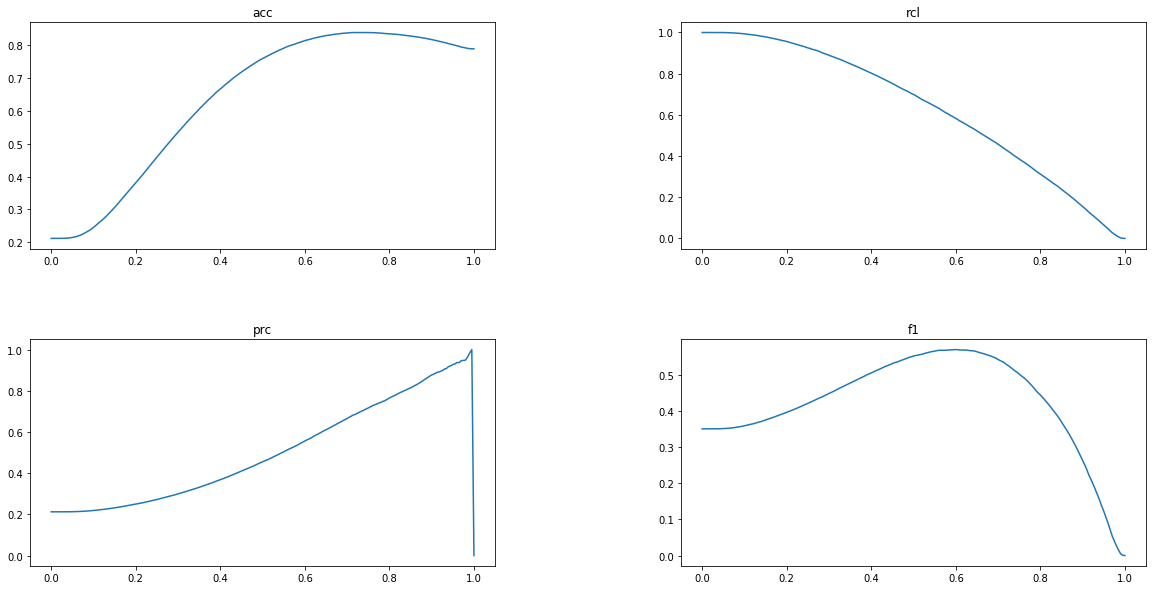

In [66]:
accs, recalls, precs, f1s = [], [], [], []
for thr in thres:
    y_pred = (probas > thr).astype(int)
    accs.append(skm.accuracy_score(y_test, y_pred))
    recalls.append(skm.recall_score(y_test, y_pred))
    precs.append(skm.precision_score(y_test, y_pred))
    f1s.append(skm.f1_score(y_test, y_pred))
    
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, (metric, name) in enumerate(zip([accs, recalls, precs, f1s], ['acc', 'rcl', 'prc', 'f1']), start=1):
    fig.add_subplot(2, 2, i)
    plt.plot(thres, metric)
    plt.title(name)


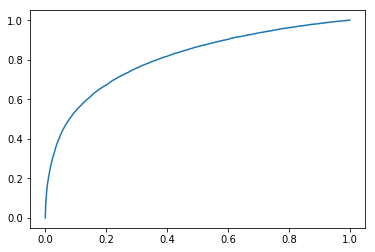

In [67]:
tpr, fpr, _ = roc_curve(y_test, probas)
plt.plot(tpr, fpr);

In [68]:
best_thres = thres[np.argmax(f1s)]
y_pred = (probas > best_thres).astype(int)
print('Best threshold: ', best_thres)
print('Acc for max f1 threshold: ', skm.accuracy_score(y_test, y_pred))
print('Max acc : ', max(accs))
print('Recall : ', skm.recall_score(y_test, y_pred))
print('Precision: ', skm.precision_score(y_test, y_pred))
print('f1: ', skm.f1_score(y_test, y_pred))

Best threshold:  0.5979899497487438
Acc for max f1 threshold:  0.8119634569517036
Max acc :  0.8375453128632563
Recall :  0.5853193130607771
Precision:  0.553626972850505
f1:  0.569032207136091


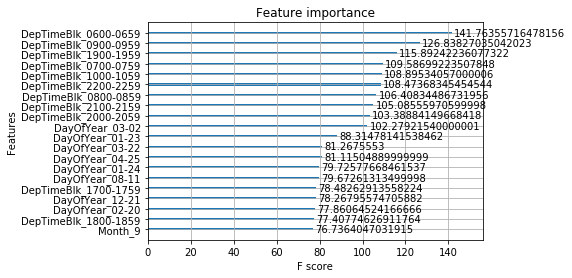

In [71]:
xgb.plot_importance(model, max_num_features=20, importance_type='gain');